# Introdução
O presente relatório explora a aplicação de técnicas de rastreamento de objetos através de Template Matching, utilizando a biblioteca OpenCV na linguagem Python. Inicia-se com casos de uso em cenários simplificados e avança para a análise em ambientes de maior complexidade visual. São examinadas diferentes estratégias de correspondência de padrões em imagens, buscando avaliar a eficácia de cada uma sob condições variadas. O documento detalha as etapas de implementação, análise metodológica e resultados obtidos, oferecendo uma visão abrangente das práticas de rastreamento em visão computacional e suas implicações práticas.


# Implementação do método no vídeo simples

## Passo A - Gravação do vídeo de 300 quadros
Foi gravado um video de um rolo de fita adesiva rolando sobre uma mesa. O vídeo se encontra em `video_simples/input_video.mp4`

## Passo B - Separação dos quadros

Foi utilizado o programa FFMPEG para extração dos quadros do vídeo, segue o comando utilizado:
```sh
ffmpeg -i input_video.mp4 ./pics/frame_%04d.png

```

## Passo C - Passar as Imagens para escala de cinza
Foi criada uma nova pasta `grayscale_pics` para armazenar as imagens em escala de cinza.

In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

grayscale_folder = "grayscale_pics"
os.makedirs(grayscale_folder, exist_ok=True)

for frame_file in sorted(os.listdir("pics")):
    frame_path = f"pics/{frame_file}"
    frame = cv2.imread(frame_path)
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    cv2.imwrite(f"{grayscale_folder}/{frame_file}", gray_frame)



## Passos D e E
foi escolhido um Template(Figura 1) para dar base ao `pattern matching`. 



\begin{figure}[H]
\centering
\includegraphics[width=0.3\textwidth]{video_simples/template.png}
\caption{Figura 1 : Template do vídeo simples}
\label{fig:templatevideo}
\end{figure}


<p align="center">Figura 1 : Template do vídeo simples</p>


Após isso os dados foram processados com os principais métodos do `openCV` para tal aplicação e foram salvos em arquivos CSV os resultados dos experimentos.

In [10]:
template = cv2.imread('template.png', 0)

methods = [
    ('cv2.TM_CCOEFF', cv2.TM_CCOEFF),
    ('cv2.TM_CCOEFF_NORMED', cv2.TM_CCOEFF_NORMED),
    ('cv2.TM_CCORR', cv2.TM_CCORR),
    ('cv2.TM_CCORR_NORMED', cv2.TM_CCORR_NORMED),
    ('cv2.TM_SQDIFF', cv2.TM_SQDIFF),
    ('cv2.TM_SQDIFF_NORMED', cv2.TM_SQDIFF_NORMED)
]

frames_folder = 'grayscale_pics'

for method_name, method in methods:
    results = [] 

    for frame_file in sorted(os.listdir(frames_folder)):
        frame_path = os.path.join(frames_folder, frame_file)
        frame = cv2.imread(frame_path, 0)
        # template matching
        res = cv2.matchTemplate(frame, template, method)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
        results.append({'Frame': frame_file, 'min_val': min_val, 'max_val': max_val})
    
    # CSV
    df = pd.DataFrame(results)
    df.to_csv(f'match_results_{method_name}.csv', index=False)

## Passo F - Plotar os gráficos dos CSVs

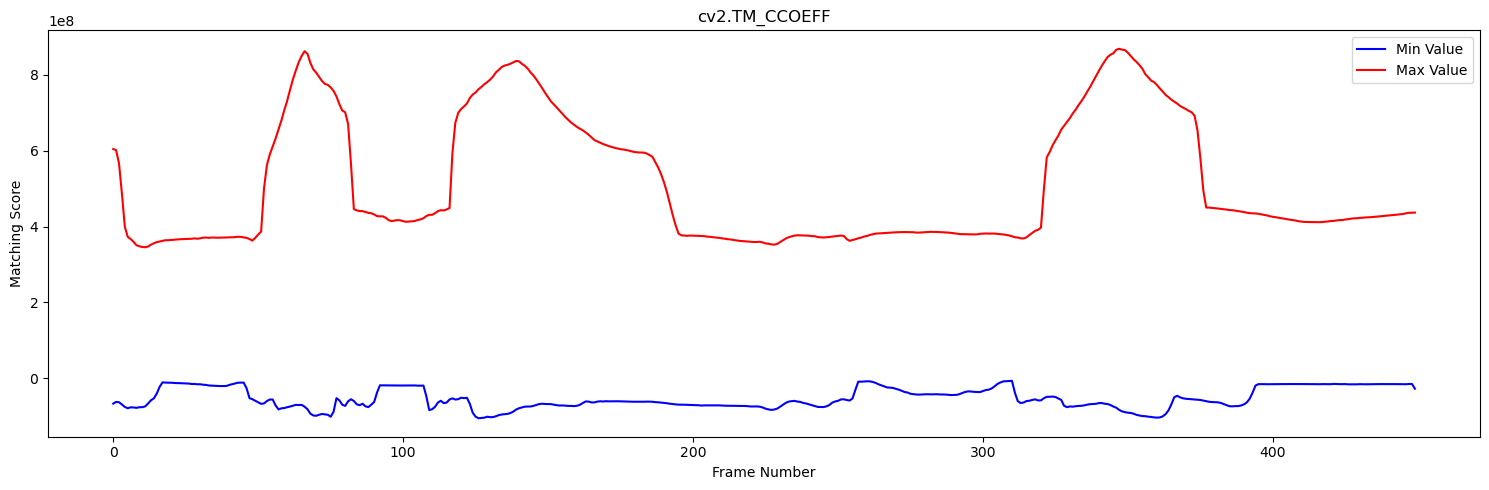

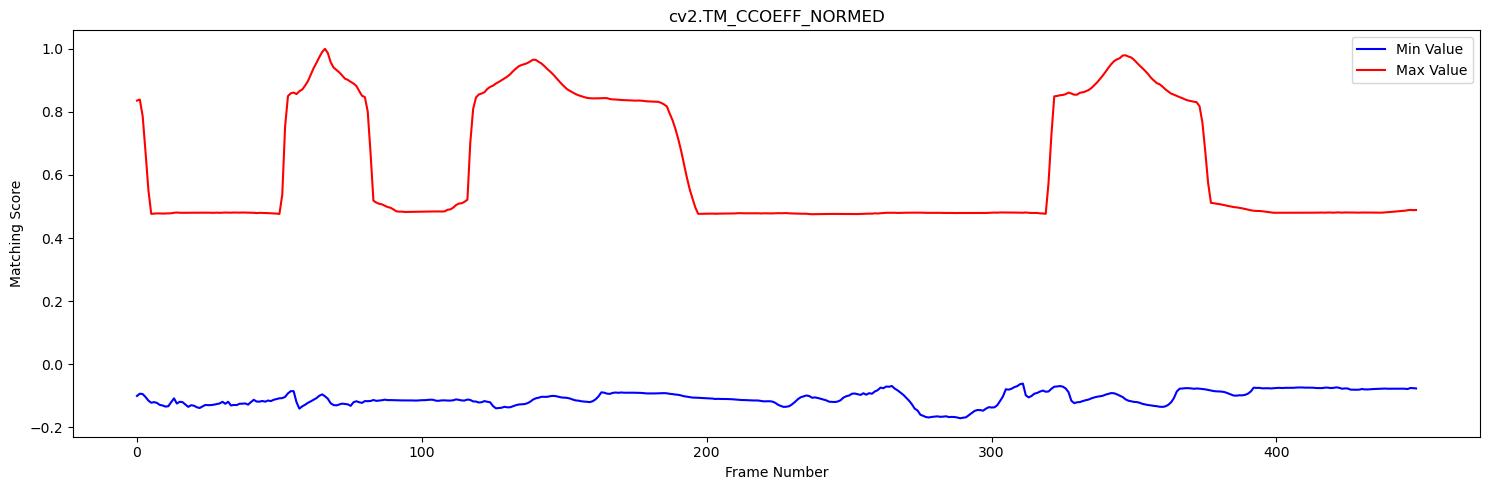

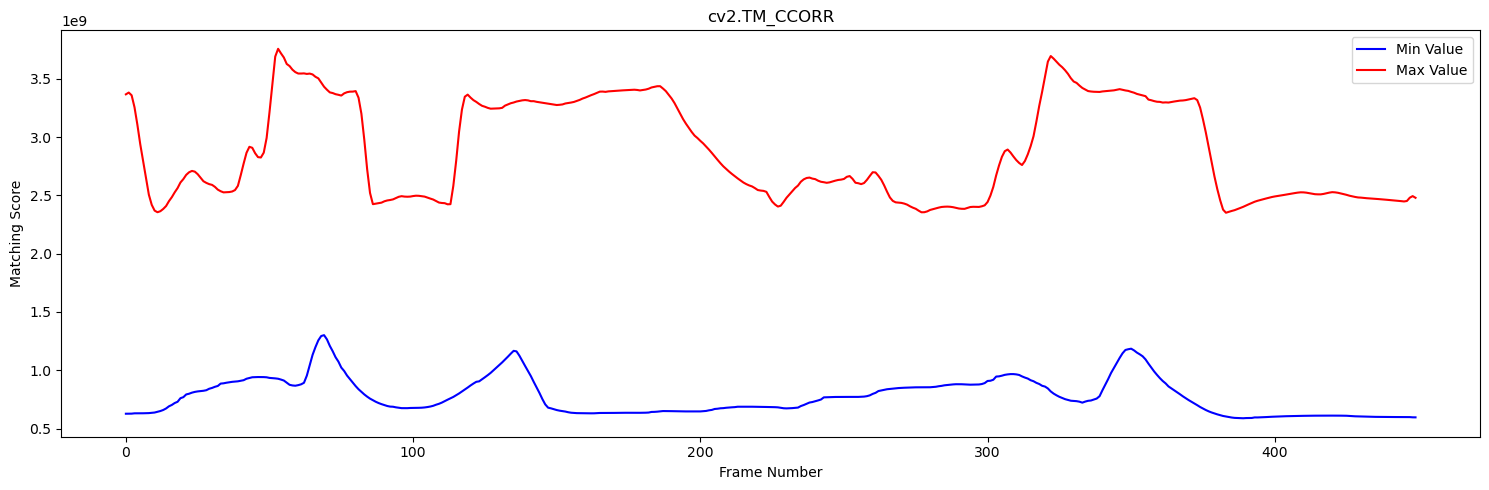

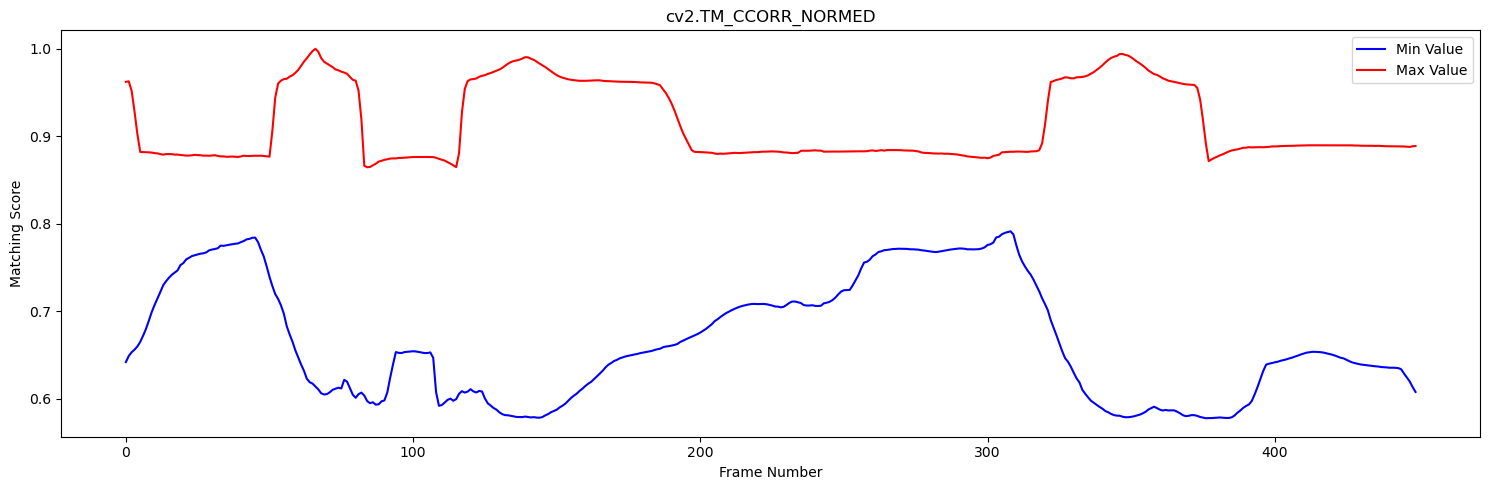

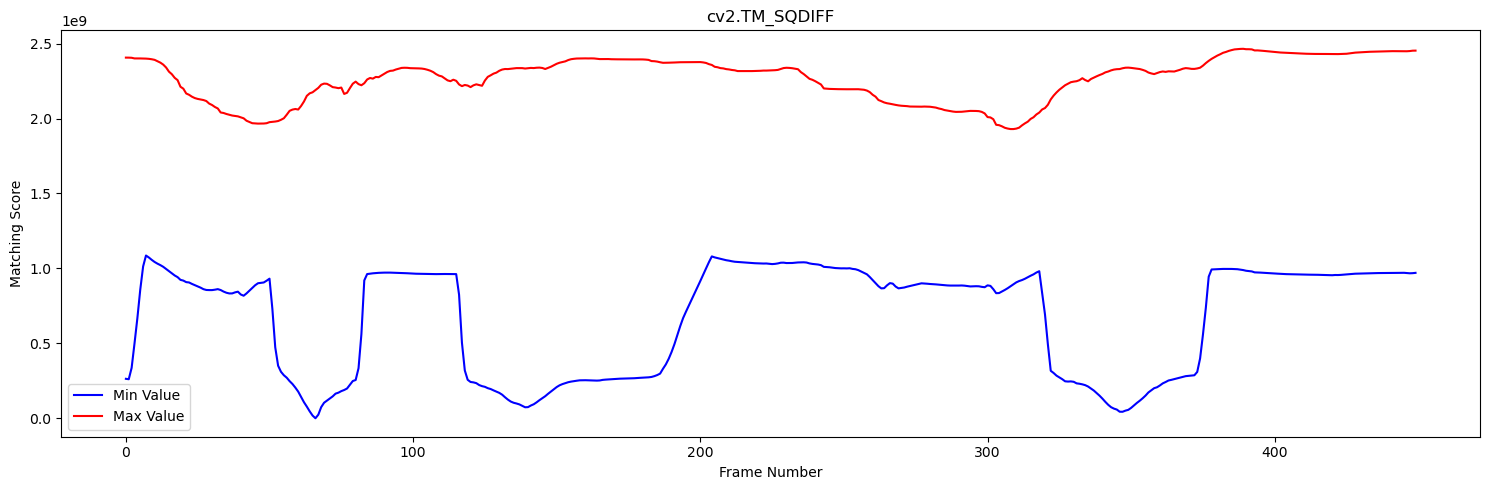

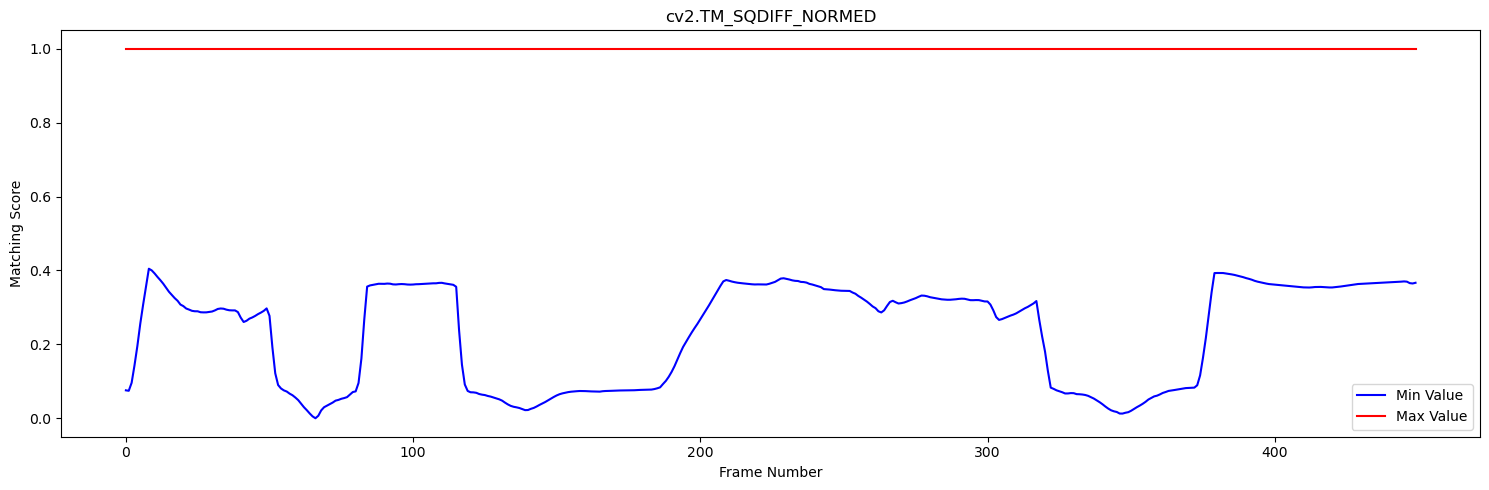

In [31]:
directory_path = 'experimentos'
all_files = os.listdir(directory_path)
csv_files = [file for file in all_files if file.endswith('.csv')]
csv_files.sort()

for index, file_name in enumerate(csv_files, 1):
    plt.figure(figsize=(15, 5))
    df = pd.read_csv(os.path.join(directory_path, file_name))
    frame_numbers = df.index
    method = file_name.replace('match_results_', '').replace('.csv', '')
    plt.plot(frame_numbers, df['min_val'], label=f'Min Value', color='blue')
    plt.plot(frame_numbers, df['max_val'], label=f'Max Value', color='red')
    plt.title(f'{method}')
    plt.xlabel('Frame Number')
    plt.ylabel('Matching Score')
    plt.legend(loc='best')  
    plt.tight_layout() 
    plt.savefig(f'experimentos/grafico_{method}.png')
    plt.show()

## Passo G - Escolha do Método

A partir da análise visual dos resultados, chegou-se a conclusão de que o `cv2.TM_CCOEFF_NORMED` é o melhor método pois apresentou a menor e mais suave variação das curvas `min_val` e `max_val`. Note que os gráficos não estão na mesma escala.

O método `cv2.TM_CCOEFF_NORMED` utiliza o coeficiente de correlação entre o template e a imagem onde está sendo pesquisado. O template é deslizado pela imagem (como uma janela de convolução 2D), e para cada posição, o coeficiente de correlação é calculado dividindo a soma do produto dos pixels pelo produto dos desvios padrão dos pixels dentro da janela do template e da região da imagem correspondente. Isso resulta em um mapa de resposta, onde cada ponto indica o quanto aquela região específica da imagem se assemelha ao template em termos de variação relativa dos pixels, independentemente da iluminação.

## Passo H - Composição do vídeo

In [29]:
frames_dir = 'pics' 
template_path = 'template.png'  
output_video_path = 'output_video.mp4'  

template = cv2.imread(template_path, 0)
template_height, template_width = template.shape[:2]

# Começa a anotar as imagens
fourcc = cv2.VideoWriter_fourcc(*'MP4V')
video_writer = None  

frame_files = sorted([f for f in os.listdir(frames_dir) if f.endswith('.png')])
for frame_file in frame_files:
    frame_path = os.path.join(frames_dir, frame_file)
    frame = cv2.imread(frame_path)
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # template matching
    result = cv2.matchTemplate(frame_gray, template, cv2.TM_CCOEFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

    top_left = max_loc
    bottom_right = (top_left[0] + template_width, top_left[1] + template_height)
    cv2.rectangle(frame, top_left, bottom_right, (0, 255, 0), 2)
    if video_writer is None:
        frame_height, frame_width = frame.shape[:2]
        video_writer = cv2.VideoWriter(output_video_path, fourcc, 20.0, (frame_width, frame_height))
    video_writer.write(frame)

if video_writer is not None:
    video_writer.release()

print("Video processing completed.")


OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


Video processing completed.


# Implementação do método no vídeo complexo

## Passo I
Foi feito um script para automatizar o processo dos passos `C` até `G`. O script foi aplicado em vídeo de um gato preto passando pela tela. A separação dos frames e seleção de um template foram feitos "Manualmente".Segue imagem(Figura 2) do template utilizado no video complexo.


\begin{figure}[H]
\centering
\includegraphics[width=0.3\textwidth]{video_complexo/template.png}
\caption{Figura 1 : Template do vídeo complexo}
\label{fig:templatevideo}
\end{figure}
Figura 2 : Template do vídeo complexo

# Conclusão
O método de `Pattern Matching` se mostrou eficiente para o rastreamento de objetos. Porém, vale notar que quando o objeto que está sendo rastreado se encontra parcialmente fora do enquadramento, a detecção fica confusa e marca a região central da imagem.

Todo o material referente aos experimentos podem ser encontrados nas pastas `video_simples` e `video_complexo`, na pasta experimentos se encontram os arquivos CSV e seus `plots`, em `pics` e `grayscale_pics` se encontram os frames dos vídeos. o `output_video.mp4` em cada pasta é o vídeo final.


# Referências
[1] “OpenCV: Template Matching”. Acesso em: 13 de novembro de 2023. [Online]. Disponível em: https://docs.opencv.org/4.5.2/d4/dc6/tutorial_py_template_matching.html


[2] “OpenCV: Template Matching”. Acesso em: 13 de novembro de 2023. [Online]. Disponível em: https://docs.opencv.org/3.4/de/da9/tutorial_template_matching.html

[3] R. Szeliski, "Computer Vision: Algorithms and Applications," London: Springer-Verlag, 2010.

[4] OpenCV, "Template Matching," OpenCV 4.5.0-dev documentation, 2023. [Online]. Available: https://docs.opencv.org/4.5.0/d4/dc6/tutorial_py_template_matching.html. [Accessed: 13-Nov-2023].